# 単純な量子回路をゼロから書く

{doc}`chsh_inequality`で、量子回路の基本的な書き方と実機での実行の仕方を学びました。そこで出てきたように、QCでは量子レジスタに特定の量子状態を実現することが計算を行うこととなります。そこで今回は、基本的なゲートを組み合わせて様々な量子状態を作る実習を行います。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

## 状態ベクトルシミュレータで量子状態を調べる

第一回の課題で利用したQCシミュレータ`AerSimulator`は、デフォルトの設定では実機と同様に量子回路の測定結果をヒストグラムとして返します。測定結果を返すということは、その出力からは量子状態の複素位相を含めた振幅は読み取れません。今回は作った量子状態をより詳細に調べるために、`AerSimulator`の状態ベクトルシミュレーション機能を利用します。状態ベクトルシミュレーションは、回路の終状態におけるすべての計算基底の確率振幅、つまりその量子状態に関する最も完全な情報を返します。

In [1]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
# qc_workbookはこのワークブック独自のモジュール（インポートエラーが出る場合はPYTHONPATHを設定するか、sys.pathをいじってください）
from qc_workbook.show_state import statevector_expr

print('notebook ready')

notebook ready


In [2]:
simulator = AerSimulator(method='statevector')
print(simulator.name())

aer_simulator_statevector


シミュレートする回路を作ります。ここでは例として前半で登場した回路1を使います。測定以外のゲートをかけていきます。

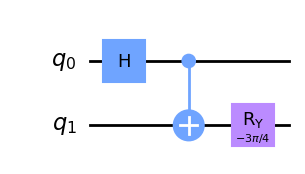

In [3]:
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)

circuit.draw('mpl')

```{caution}
回路に測定操作(`measure_all()`)を加えてしまうと、状態ベクトルシミュレータを利用して測定前の回路の量子状態を確認することができなくなります。
```

状態ベクトルシミュレーションを実行する際も`transpile`とバックエンドの`run`関数を使い、ジョブオブジェクトから結果を得ます。ただし、今回は計算結果からカウントではなく状態ベクトル（＝量子振幅の配列）を得るので`get_counts`ではなく`result.data()['statevector']`を参照します。

In [4]:
def get_statevector_array(circuit):
    # 渡された回路のコピーを使う
    circuit = circuit.copy()
    # 量子回路の終状態の状態ベクトルを保存するインストラクション
    circuit.save_statevector()
    # 再び「おまじない」のtranspileをしてから、run()に渡す
    circuit = transpile(circuit, backend=simulator)
    job = simulator.run(circuit)
    result = job.result()
    qiskit_statevector = result.data()['statevector']

    # result.data()['statevector']は通常の配列オブジェクト（ndarray）ではなくqiskit独自のクラスのインスタンス
    # ただし np.asarray() で numpy の ndarray に変換可能
    return np.asarray(qiskit_statevector)

statevector = get_statevector_array(circuit)
print(type(statevector), statevector.dtype)
print(statevector)

<class 'numpy.ndarray'> complex128
[ 0.27059805+0.j  0.65328148+0.j -0.65328148+0.j  0.27059805+0.j]


状態ベクトルは`np.asarray()`でnumpy配列に変換できます。データタイプは128ビットの複素数（実部と虚部それぞれ64ビット）です。配列のインデックスがそのまま二進数としてみなした計算基底の値に対応しています。

状態ベクトルデータから数式の文字列を作る[`statevector_expr`という関数](https://github.com/UTokyo-ICEPP/qc-workbook/tree/master/source/qc_workbook/show_state.py)はこのワークブックのレポジトリからインポートしています。

In [5]:
expr = statevector_expr(statevector)

# Math()はLaTeXをタイプセットする関数
Math(expr)

<IPython.core.display.Math object>

前回より、{eq}`回路1 <eqn-circuit1>`は$\frac{1}{\sqrt{2}} (s\ket{00} + c\ket{01} - c\ket{10} + s\ket{11})$（$s:=\sin(\pi/8)=0.271\sqrt{2}$, $c:=\cos(\pi/8)=0.653\sqrt{2}$）という状態を作るもののはずでした。実際に計算された終状態の状態ベクトルが一致しています。

(other_gates)=
## その他のゲート

{doc}`chsh_inequality`で、よく使われる1量子ビットゲートと2量子ビット制御ゲートを紹介しましたが、他にも知っておくと便利なゲートがいくつかあります。

### 1、2量子ビット

```{list-table}
:header-rows: 1
* - ゲート名
  - 対象量子ビット数
  - 説明
  - Qiskitコード
* - $\sqrt{X}$, SX
  - 1
  - 計算基底それぞれに対して、以下の変換をする。
    ```{math}
    \sqrt{X} \ket{0} = \frac{1}{2} \left[(1 + i) \ket{0} + (1 - i) \ket{1}\right] \\
    \sqrt{X} \ket{1} = \frac{1}{2} \left[(1 - i) \ket{0} + (1 + i) \ket{1}\right]
    ```
  - circuit.sx(i)
* - $P$
  - 1
  - パラメータ$\phi$を取り、$\ket{1}$に位相$e^{i\phi}$をかける。$P(\phi)$は$R_{z}(\phi)$と等価なので、1量子ビットゲートとして利用する分にはどちらでも同じ結果が得られる。
  - `circuit.p(phi, i)`
* - $C^i_j[P]$
  - 2
  - パラメータ$\phi$を取り、ビット$i, j$が1であるような計算基底の位相を$\phi$前進させる。
    ```{math}
    C^i_j[P(\phi)] \ket{00} = \ket{00} \\
    C^i_j[P(\phi)] \ket{01} = \ket{01} \\
    C^i_j[P(\phi)] \ket{10} = \ket{10} \\
    C^i_j[P(\phi)] \ket{11} = e^{i\phi} \ket{11}
    ```
  - `circuit.cp(phi, i, j)`
* - SWAP
  - 2
  - 二つの量子ビットの量子状態を交換する。CNOT三回で実装できる。
    ```{math}
    \begin{align}
    & C^0_1[X]C^1_0[X]C^0_1[X] (\alpha \ket{00} + \beta \ket{01} + \gamma \ket{10} + \delta \ket{11}) \\
    = & C^0_1[X]C^1_0[X] (\alpha \ket{00} + \beta \ket{01} + \gamma \ket{11} + \delta \ket{10}) \\
    = & C^0_1[X] (\alpha \ket{00} + \beta \ket{11} + \gamma \ket{01} + \delta \ket{10}) \\
    = & \alpha \ket{00} + \beta \ket{10} + \gamma \ket{01} + \delta \ket{11}
    \end{align}
    ```
  - `circuit.swap(i, j)`
```

### 3量子ビット以上

量子レジスタに対する全ての操作が1量子ビットゲートと2量子ビット制御ゲート（実際にはCNOTのみ）の組み合わせで表現できることはすでに触れましたが、実際に量子回路を書くときには3つ以上の量子ビットにかかるゲートを使用したほうがアルゴリズムをコンパクトに表現できます（最終的には1量子ビットゲートと2量子ビット制御ゲートに分解して実行されます）。

3量子ビット以上にかかるゲートも基本は制御ゲートで、よく使われるのは制御ビットが複数あるような多重制御（multi-controlled）ゲート$C^{ij\dots}_{k}[U]$です。そのうち制御ビットが2つで標的ビット1つに$X$をかける$C^{ij}_{k}[X]$は特別多用され、Toffoliゲートとも呼ばれます。

多重制御ゲートでない3量子ビットゲートの例として、controlled SWAPというものも存在します。制御ビット1つで他の2つの量子ビットの間の量子状態交換を制御します。当然制御ビットを増やしたmulti-controlled SWAPというものも考えられます。

Qiskitで多重制御ゲートに対応するコードは一般に`circuit.mc?(parameters, [controls], target)`という形を取ります。例えばToffoliゲートは

```{code-block} python
circuit.mcx([i, j], k)
```

で、$C^{ij}_{k}[R_y]$は

```{code-block} python
circuit.mcry(theta, [i, j], k)
```

となります。

## 量子状態生成

それでは、これまでに登場したゲートを使って量子状態生成のエクササイズをしましょう。

実は`statevector_expr`関数には回路オブジェクトを直接渡すこともできるので（内部でシミュレータを実行し状態ベクトルオブジェクトを取得する）、ここからはその機能を利用します。また、コード中登場する`amp_norm`や`phase_norm`は、表示される数式において振幅や位相の共通因子をくくりだすために設定されています。

各問題のコードセルには、ヒントとして回路が一部分だけ書かれています。残りの`circuit.?`の部分を埋めてみましょう。答えは一行とは限りません。また、同じ状態を作る量子回路は無数に存在するので、ヒントを消して独自の実装をしても構いません。

### 問題1: 1量子ビット、相対位相付き

**問題**

1量子ビットに対して状態

$$
\frac{1}{\sqrt{2}}\left(\ket{0} + i\ket{1}\right)
$$

を作りなさい。

In [6]:
circuit = QuantumCircuit(1)
##################
### EDIT BELOW ###
##################
circuit.h(0)
# circuit.?
##################
### EDIT ABOVE ###
##################

expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

**解答**

````{toggle}
正解は無限に存在しますが、上の回路ですでにアダマールゲートがかかっているので、最も手っ取り早いのは

```{code-block} python
circuit.h(0)
circuit.p(np.pi / 2., 0)
```

でしょう。自分で入力して確認してみてください。

また、上で触れたように、単一量子ビットの場合、$U_3$ゲートを使えば任意の状態を一つのゲート操作で生成できます。$U_3$を使った解答は

```{code-block} python
circuit.u3(np.pi / 2., np.pi / 2., 0., 0)
```

です。
````

### 問題2: ベル状態、相対位相付き

**問題**

2量子ビットに対して状態

$$
\frac{1}{\sqrt{2}}\left(\ket{0} + i\ket{3}\right)
$$

を作りなさい。

In [7]:
circuit = QuantumCircuit(2)

##################
### EDIT BELOW ###
##################
# circuit.?
circuit.cx(0, 1)
##################
### EDIT ABOVE ###
##################

expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

**解答**

````{toggle}
問題1の結果を利用すると簡単です。初期状態は両ビットとも$\ket{0}$なので、2ビットレジスタに対して問題1の操作をすると状態$1/\sqrt{2}(\ket{0} + i\ket{1})\ket{0}$ができます。ここでビット0から1にCNOTをかけると、$\ket{1}\ket{0} \rightarrow \ket{1}\ket{1}$となるので、望む状態が実現します。

```{code-block} python
circuit.h(0)
circuit.p(np.pi / 2., 0)
circuit.cx(0, 1)
```
````

### 問題3: GHZ状態

**問題**

3量子ビットに対して状態

$$
\frac{1}{\sqrt{2}} (\ket{0} + \ket{7})
$$

を作りなさい。

In [8]:
circuit = QuantumCircuit(3)

##################
### EDIT BELOW ###
##################
# circuit.?
circuit.mcx([0, 1], 2)
##################
### EDIT ABOVE ###
##################

expr = statevector_expr(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))
Math(expr)

<IPython.core.display.Math object>

**解答**

````{toggle}
Bell状態の生成と発想は同じですが、多重制御ゲート$C^{01}_2[X]$を利用します。

```{code-block} python
circuit.h(0)
circuit.cx(0, 1)
circuit.mcx([0, 1], 2)
```
````

### 問題4: Equal superposition

**問題**

一般の$n$量子ビットに対して状態

$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k}
$$

を作る回路を考え、$n=4$のケースを実装しなさい。

In [9]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
# circuit.?
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = 2 ** (num_qubits // 2)
expr = statevector_expr(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n))
Math(expr)

<IPython.core.display.Math object>

**解答**

````{toggle}
Equal superpositionと呼ばれるこの状態は、量子計算でおそらく一番多様される状態です。一見複雑に思えますが、$n$桁の二進数で$0$から$2^n-1$までの数を表現すると、全ての0/1の組み合わせが登場するということを考えると、

$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \otimes \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \otimes \cdots \otimes \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})
$$

と、$n$個の$1/\sqrt{2}(\ket{0} + \ket{1})$の積と等しいことがわかります。つまり各ビットに対してアダマールゲートをかけた状態にほかならず、

```{code-block} python
for i in range(4):
    circuit.h(i)
```
が正解です。
````

### 問題5: 特定の基底の符号を反転させる

**問題**

問題4の4ビットequal superposition状態において、基底$\ket{5}$の符号を反転させなさい。

In [10]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
for i in range(num_qubits):
    circuit.h(i)

# circuit.?
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = 2 ** (num_qubits // 2)
expr = statevector_expr(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n))
Math(expr)

<IPython.core.display.Math object>

**解答**

````{toggle}
$\ket{5}=\ket{0101}$の符号を反転させるには、4つの量子ビットが0, 1, 0, 1という値を取っている状態のみに作用するゲートを使います。必然的に多重制御ゲートが用いられますが、残念ながら制御ゲートはビットの値が1であるときにしか働きません。そこで、まず$\ket{0101}$を$\ket{1111}$に変換し、その上で$C^{012}_{3}[P(\pi)]$を使います[^mcz]。符号を反転させたら、最初の操作の逆操作をして$\ket{1111}$を$\ket{0101}$に変換します。

```{code-block} python
for i in range(4):
    circuit.h(i)

circuit.x(1)
circuit.x(3)
circuit.mcp(np.pi, [0, 1, 2], 3)
circuit.x(1) # Xの逆操作はX
circuit.x(3)
```

ビット1と3にかかっている$X$ゲートは当然他の基底にも影響するので、例えば$\ket{0011}$は$\ket{0110}$となります。しかし、1と3に$X$をかけて$\ket{1111}$になるのは$\ket{0101}$だけなので、逆操作でちゃんと「後片付け」さえすれば、この一連の操作で$\ket{5}$だけをいじることができます。

[^mcz]: （多重）制御$P$ゲートはどのビットを制御と呼んでも標的と呼んでも同じ作用をするので、$C^{123}_0[P(\pi)]$でもなんでも構いません。
````

(equal_superposition_with_phase)=
### 問題6: Equal superpositionに位相を付ける

**問題**

一般の$n$量子ビットに対して状態

$$
\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i s k/2^n} \ket{k} \quad (s \in \mathbb{R})
$$

を作る回路を考え、$n=6, s=2.5$のケースを実装しなさい。

In [11]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

s = 2.5

##################
### EDIT BELOW ###
##################
#for i in range(num_qubits):
#    circuit.h(i)
#
# circuit.?
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm, phase_norm=phase_norm)
Math(expr)

<IPython.core.display.Math object>

**解答**

````{toggle}
問題4と同じように、この状態も個々の量子ビットにおける$\ket{0}$と$\ket{1}$の重ね合わせの積として表現できます。そのためには$k$の二進数表現$k = \sum_{m=0}^{n-1} 2^m k_m \, (k_m=0,1)$を用いて、$\ket{k}$の位相を

$$
\exp\left(2\pi i \frac{sk}{2^n}\right) = \exp \left(2\pi i \frac{s}{2^n} \sum_{m=0}^{n-1} 2^m k_m\right) = \prod_{m=0}^{n-1} \exp \left(2\pi i \frac{s}{2^{n-m}} k_m\right)
$$

と分解します。一方

$$
\ket{k} = \ket{k_{n-1}} \otimes \ket{k_{n-2}} \otimes \cdots \ket{k_0}
$$

なので、

$$
e^{2\pi i sk/2^n} \ket{k} = e^{2\pi i sk_{n-1}/2} \ket{k_{n-1}} \otimes \cdots \otimes e^{2\pi i sk_{1}/2^{n-1}} \ket{k_1} \otimes e^{2\pi i sk_{0}/2^n} \ket{k_{0}}.
$$

最後に、$k_m = 0$ならば$e^{2\pi i sk_{m}/2^n} = 1$であることから、

$$
\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i sk/2^n} \ket{k} = \frac{1}{\sqrt{2}} \left(\ket{0} + e^{2\pi i s/2} \ket{1}\right) \otimes \cdots \otimes \frac{1}{\sqrt{2}} \left(\ket{0} + e^{2\pi i s/2^n} \ket{1}\right)
$$

がわかります。

```{code-block} python
for m in range(num_qubits):
    circuit.h(m)
    circuit.p(2. * np.pi * s / (2 ** (num_qubits - m)), m)
```

が正解となります。
````

## 量子計算プリミティブ

量子計算をする回路を実装するにあたって、いくつか知っておくと便利な「パーツ」があります。これらは単体で「アルゴリズム」と呼べるものではなく、量子コンピュータを使った様々な計算の過程で、状況に合わせて応用する回路の雛形です。

### 条件分岐

古典的には、ほとんどのプログラムが条件分岐`if ... else ...`がなければ成り立ちません。量子コンピュータのプログラムである量子回路で、条件分岐に対応するものはなんでしょうか？

#### 測定結果に基づいた分岐

一つ考えうるのは、「回路のある時点である量子レジスタを測定し、その結果に応じて異なるゲートを他のレジスタにかける」という構造です。これまで測定とは量子回路の一番最後で行うものだと言ってきましたが、実は測定も一つのオペレーションとしてどこで行っても構いません。ただし、例えば状態$\ket{\psi} = \sum_{k} c_k \ket{k}$にあるレジスタを計算基底で測定し、$j$というビット列が得られたとすると、そのレジスタは$\ket{j}$という状態に「射影」されてしまい、元々の$\{c_k\}$という振幅の情報は失われます。

例として、サイズ4のレジスタ1にequal superpositionを実現し、測定して得られた計算基底$j$に応じて$R_y(2 \pi \frac{j}{16})$をレジスタ2の量子ビットにかける回路を書いてみます。

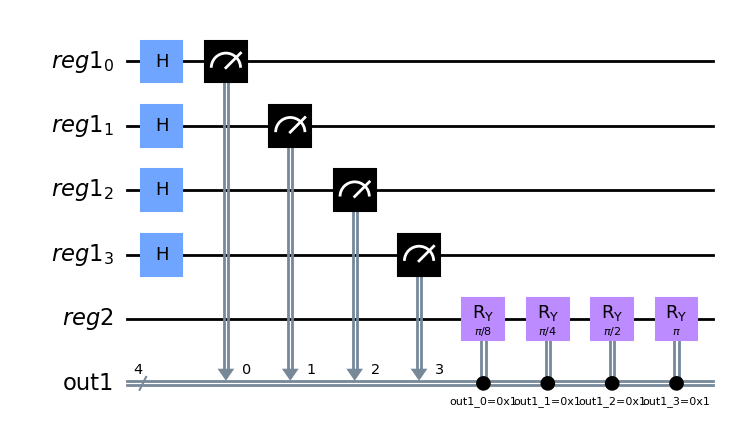

In [12]:
register1 = QuantumRegister(4, name='reg1')
register2 = QuantumRegister(1, name='reg2')
output1 = ClassicalRegister(4, name='out1') # 測定結果を保持する「古典レジスタ」オブジェクト

circuit = QuantumCircuit(register1, register2, output1)

# register1にequal superpositionを実現
circuit.h(register1)
# register1を測定し、結果をoutput1に書き込む
circuit.measure(register1, output1)

# output1の各位iの0/1に応じて、dtheta * 2^iだけRyをかけると、全体としてRy(2pi * j/16)が実現する
dtheta = 2. * np.pi / 16.

for idx in range(4):
    # circuit.***.c_if(classical_bit, 1) <- classical_bitが1のときに***ゲートをかける
    angle = dtheta * (2 ** idx)
    circuit.ry(angle, register2[0]).c_if(output1[idx], 1)

circuit.draw('mpl')

測定オペレーションが入っているので、この回路をstatevector simulatorに渡すと、シミュレーションを実行するごとにレジスタ1の状態がランダムに決定されます。次のセルを複数回実行して、上の回路が狙い通り動いていることを確認してみましょう。

入力と出力のレジスタの値が別々に表示されるよう、`statevector_expr`の`register_sizes`という引数を利用して、5ビットの回路を4ビットと1ビットに分けて解釈するよう指定します。

In [13]:
Math(statevector_expr(circuit, register_sizes=[4, 1]))

# cos(pi*0/16) = 1.000, sin(pi*0/16) = 0.000
# cos(pi*1/16) = 0.981, sin(pi*1/16) = 0.195
# cos(pi*2/16) = 0.924, sin(pi*2/16) = 0.383
# cos(pi*3/16) = 0.831, sin(pi*3/16) = 0.556
# cos(pi*4/16) = 0.707, sin(pi*4/16) = 0.707
# cos(pi*5/16) = 0.556, sin(pi*5/16) = 0.831
# cos(pi*6/16) = 0.383, sin(pi*6/16) = 0.924
# cos(pi*7/16) = 0.195, sin(pi*7/16) = 0.981
# cos(pi*8/16) = 0.000, sin(pi*8/16) = 1.000
# cos(pi*9/16) = -0.195, sin(pi*9/16) = 0.981
# cos(pi*10/16) = -0.383, sin(pi*10/16) = 0.924
# cos(pi*11/16) = -0.556, sin(pi*11/16) = 0.831
# cos(pi*12/16) = -0.707, sin(pi*12/16) = 0.707
# cos(pi*13/16) = -0.831, sin(pi*13/16) = 0.556
# cos(pi*14/16) = -0.924, sin(pi*14/16) = 0.383
# cos(pi*15/16) = -0.981, sin(pi*15/16) = 0.195

<IPython.core.display.Math object>

#### 条件分岐としての制御ゲート

上の方法は古典プログラミングとの対応が明らかですが、あまり「量子ネイティブ」な計算の仕方とは言えません。量子計算でより自然なのは、重ね合わせ状態の生成を条件分岐とみなし、全ての分岐が回路の中で同時に扱われるようにすることです。それは結局制御ゲートを使うということに他なりません。

上の回路の量子条件分岐版は以下のようになります。

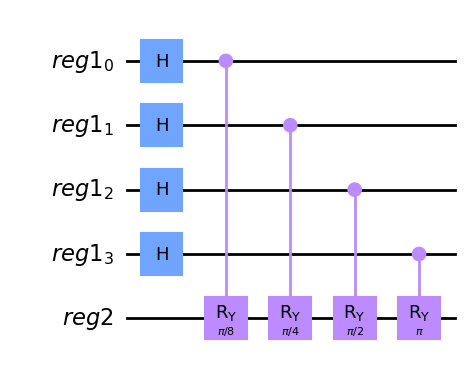

In [14]:
register1 = QuantumRegister(4, name='reg1')
register2 = QuantumRegister(1, name='reg2')

circuit = QuantumCircuit(register1, register2)

circuit.h(register1)

dtheta = 2. * np.pi / 16.

for idx in range(4):
    circuit.cry(dtheta * (2 ** idx), register1[idx], register2[0])

circuit.draw('mpl')

今度は全ての分岐が重ね合わさった量子状態が実現しています。

In [15]:
lines = statevector_expr(circuit, register_sizes=[4, 1], terms_per_row=6)
Math(r' \\ '.join(lines))

<IPython.core.display.Math object>

### 関数

整数値変数$x$を引数に取り、バイナリ値$f(x) \in \{0, 1\}$を返す関数$f$を量子回路で実装する一つの方法は、

$$
U_{f}\ket{y}\ket{x} = \ket{y \oplus f(x)}\ket{x} \quad (y \in \{0, 1\})
$$

となるようなゲートの組み合わせ$U_{f}$を見つけることです。ここで、$\oplus$は「2を法とする足し算」つまり和を2で割った余りを表します（$y=0$なら$y \oplus f(x) = f(x)$、$y=1$なら$y \oplus f(x) = 1 - f(x)$）。要するに、$U_{f}$は「$f(x)$の値が0だったら何もせず、1だったら右のケットをビット反転させる」というオペレーションです。

このような関数回路は量子アルゴリズムを考える上で頻出します。二点指摘しておくと、
- 単に$U_{f}\ket{y}\ket{x} = \ket{f(x)}\ket{x}$とできないのは、量子回路は可逆でなければいけないという制約があるからです。もともと右のレジスタにあった$y$という情報を消してしまうような回路は不可逆なので、そのような$U_{f}$の回路実装は存在しません。
- 関数の返り値がバイナリというのはかなり限定的な状況を考えているようですが、一般の整数値関数も単に「1の位を返す関数$f_0$」「2の位を返す関数$f_1$」...と重ねていくだけで表現できます。

さて、このような$U_f$を実装する時も、やはり鍵となるのは制御ゲートです。例えば、実際に4ビット整数値関数に拡張した$f=f_3 f_2 f_1 f_0$を$x \in \{0, \dots, 7\}$を15から引く関数としたとき、それに対応する回路は

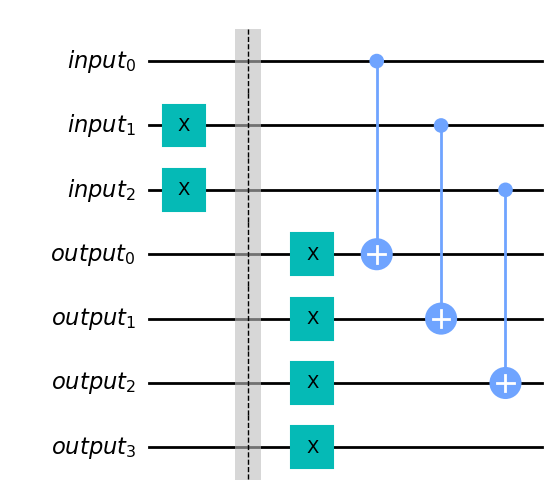

In [16]:
input_register = QuantumRegister(3, name='input')
output_register = QuantumRegister(4, name='output')

circuit = QuantumCircuit(input_register, output_register)

# input_registerに適当な値（6）を入力
circuit.x(input_register[1])
circuit.x(input_register[2])

circuit.barrier()

# ここからが引き算をするU_f
# まずoutput_registerの全てのビットを立てる
circuit.x(output_register)
for idx in range(3):
    # その上で、CNOTを使ってinput_registerでビットが1である時にoutput_registerの対応するビットが0にする
    circuit.cx(input_register[idx], output_register[idx])

circuit.draw('mpl')

In [17]:
Math(statevector_expr(circuit, register_sizes=[3, 4]))

<IPython.core.display.Math object>

入力レジスタの状態を色々変えて、状態ベクトルの変化を見てみましょう。

### 状態ベクトルの内積

次に紹介するのは、二つの状態$\ket{\psi}$と$\ket{\phi}$の間の内積の絶対値自乗$|\braket{\psi}{\phi}|^2$を計算するテクニックです。

まず、量子計算において二つの状態ベクトルの間の内積は、

$$
\begin{split}
\ket{\psi} = \sum_{k=0}^{2^n-1} c_k \ket{k} \\
\ket{\phi} = \sum_{k=0}^{2^n-1} d_k \ket{k}
\end{split}
$$

に対して

```{math}
:label: inner_product
\braket{\psi}{\phi} = \sum_{k=0}^{2^n-1} c^{*}_k d_k
```

で定義できます。内積の重要な性質として

$$
\begin{split}
0 \leq |\braket{\psi}{\phi}|^2 \leq 1 \\
|\braket{\psi}{\phi}|^2 = 1 \; \text{iff} \; \ket{\psi} \sim \ket{\phi}
\end{split}
$$

（単位ベクトルにおけるCauchy-Schwarzの不等式）があります。二つの状態ベクトルが物理的に同一であるときに内積の絶対値が最大になるので、内積の絶対値は状態の「近さ」を表す指標になります。また、内積が0になるとき、二つのベクトルは直交すると言います。

それから、状態ベクトルの内積と密接に関わる量として、状態ベクトルの重ね合わせ

$$
\ket{\psi} + \ket{\phi} = \sum_k (c_k + d_k) \ket{k} = \sum_k z_k \ket{k}
$$

の2-ノルム

$$
\lVert \ket{\psi} + \ket{\phi} \rVert_2 = \sum_k |z_k|^2
$$

があります。単一の状態ベクトル$\ket{\psi}$では「量子力学の決まりごと」$\braket{\psi}{\psi} = \sum_k |c_k|^2 = 1$（$\ket{\psi}$は単位ベクトル）より2-ノルムが常に1ですが、上のような重ね合わせに対しては

$$
\begin{split}
\sum_k |z_k|^2 & = \sum_k (c_k + d_k)^* (c_k + d_k) \\
& = \sum_k \left( |c_k|^2 + |d_k|^2 + c_k^* d_k + d_k^* c_k \right) \\
& = 2 \left(1 + \mathrm{Re}\braket{\psi}{\phi} \right)
\end{split}
$$

となり、2-ノルムが内積$\braket{\psi}{\phi}$に依存します。

内積や2-ノルムの計算は量子計算の様々な局面で登場します。それではその計算をする量子回路の組み方を見ていきましょう。実は2通りの異なる方法があります。

#### SWAPテスト

状態$\ket{\psi}$と$\ket{\phi}$（具体的に実装するためここでは3量子ビットの状態とする）が二つのレジスタに実現しているような次の回路を実行し、`test_output`で0が出る確率を$P_0$、1が出る確率を$P_1$とすると、

```{math}
:label: swap_test
P_0 - P_1 = |\braket{\psi}{\phi}|^2
```

が成り立ちます。

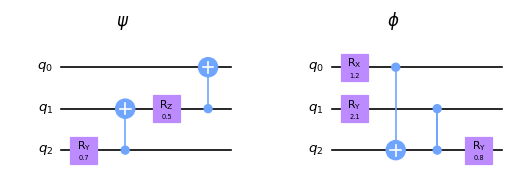

In [18]:
data_width = 3

fig, axs = plt.subplots(1, 2)

# 適当な状態|ψ>を作る回路
psi_circuit = QuantumCircuit(data_width, name='|ψ>')
psi_circuit.ry(0.7, 2)
psi_circuit.cx(2, 1)
psi_circuit.rz(0.5, 1)
psi_circuit.cx(1, 0)
psi_circuit.draw('mpl', ax=axs[0])
axs[0].set_title(r'$\psi$')

# 適当な状態|φ>を作る回路
phi_circuit = QuantumCircuit(data_width, name='|φ>')
phi_circuit.rx(1.2, 0)
phi_circuit.ry(2.1, 1)
phi_circuit.cx(0, 2)
phi_circuit.cz(1, 2)
phi_circuit.ry(0.8, 2)
phi_circuit.draw('mpl', ax=axs[1])
axs[1].set_title(r'$\phi$')

# パーツが全て揃ったので、内積を計算する回路を作る
reg_data1 = QuantumRegister(data_width, name='data1')
reg_data2 = QuantumRegister(data_width, name='data2')
reg_test = QuantumRegister(1, name='test')
out = ClassicalRegister(1, name='out')

circuit = QuantumCircuit(reg_data1, reg_data2, reg_test, out, name='SWAP_test')
# 状態|ψ>と|φ>をデータレジスタに実現
# 他の回路や別に定義したゲートを回路オブジェクトに組み込むときはappend()メソッドを使う
# qargsでもとの回路の量子ビットを組み込み先のどの量子ビットに対応させるかを指定する
circuit.append(psi_circuit, qargs=reg_data1)
circuit.append(phi_circuit, qargs=reg_data2)

# 回路図が見やすくなるようにバリアを入れる（計算上は何もしない操作）
circuit.barrier()

# ここからがSWAPテスト
circuit.h(reg_test)

for idx in range(data_width):
    circuit.cswap(reg_test[0], reg_data1[idx], reg_data2[idx])

circuit.h(reg_test)

circuit.measure(reg_test, out)

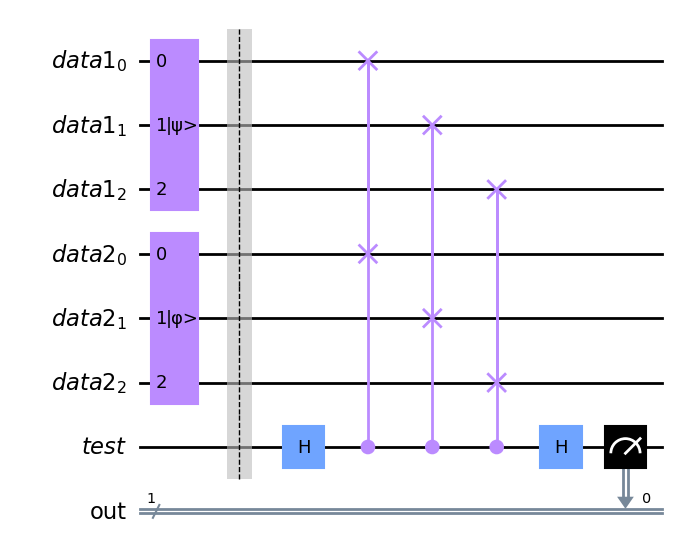

In [19]:
circuit.draw('mpl')

式{eq}`swap_test`を導いてみましょう。

```{toggle}
全体回路の状態は初期状態$\ket{0}_{\mathrm{t}}\ket{0}_{\mathrm{d2}}\ket{0}_{\mathrm{d1}}$から始めて

$$
\begin{align}
& \ket{0}_{\mathrm{t}} \ket{\phi}_{\mathrm{d2}}\ket{\psi}_{\mathrm{d1}} \\
\rightarrow & \frac{1}{\sqrt{2}} (\ket{0} + \ket{1})_{\mathrm{t}} \ket{\phi}_{\mathrm{d2}} \ket{\psi}_{\mathrm{d1}} \\
\rightarrow & \frac{1}{\sqrt{2}} (\ket{0}_{\mathrm{t}} \ket{\phi}_{\mathrm{d2}} \ket{\psi}_{\mathrm{d1}} + \ket{1}_{\mathrm{t}} \ket{\psi}_{\mathrm{d2}} \ket{\phi}_{\mathrm{d1}}) \\
\rightarrow & \frac{1}{2} \left[ (\ket{0} + \ket{1})_{\mathrm{t}} \ket{\phi}_{\mathrm{d2}} \ket{\psi}_{\mathrm{d1}} + (\ket{0} - \ket{1})_{\mathrm{t}} \ket{\psi}_{\mathrm{d2}} \ket{\phi}_{\mathrm{d1}} \right] \\
= & \frac{1}{2} \left[ \ket{0}_{\mathrm{t}} (\ket{\phi}_{\mathrm{d2}} \ket{\psi}_{\mathrm{d1}} + \ket{\psi}_{\mathrm{d2}} \ket{\phi}_{\mathrm{d1}}) + \ket{1}_{\mathrm{t}} (\ket{\phi}_{\mathrm{d2}} \ket{\psi}_{\mathrm{d1}} - \ket{\psi}_{\mathrm{d_2}} \ket{\phi}_{\mathrm{d1}}) \right]
\end{align}
$$

と移っていきます。最後にテストレジスタ$\mathrm{t}$を測定します。

ここでポイントは、一般に二つのレジスタ$a, b$上に作られる量子状態

$$
\sum_{kl} z_{kl} \ket{l}_b \ket{k}_a
$$

のレジスタ$b$だけを測定したとき、結果$j$が得られる確率は

$$
P_j = \sum_k |z_{kj}|^2 = \left\lVert \sum_k z_{kj} \ket{k}_a \right\rVert_2
$$

つまり$\ket{j}_b$の「係数」になっている$a$レジスタのベクトルの2-ノルムである、という点です。

したがって、テストレジスタで0と1が測定される確率$P_0$と$P_1$は

$$
\begin{align}
P_0 & = \frac{1}{4} \lVert (\ket{\phi}_{\mathrm{d2}} \ket{\psi}_{\mathrm{d1}} + \ket{\psi}_{\mathrm{d2}} \ket{\phi}_{\mathrm{d1}}) \rVert_2 = \frac{1}{2} (1 + \mathrm{Re}\braket{\psi}{\phi}\braket{\phi}{\psi}) \\
P_1 & = \frac{1}{4} \lVert (\ket{\phi}_{\mathrm{d2}} \ket{\psi}_{\mathrm{d1}} - \ket{\psi}_{\mathrm{d2}} \ket{\phi}_{\mathrm{d1}}) \rVert_2 = \frac{1}{2} (1 - \mathrm{Re}\braket{\psi}{\phi}\braket{\phi}{\psi})
\end{align}
$$

となります。$\braket{\psi}{\phi}\braket{\phi}{\psi} = |\braket{\psi}{\phi}|^2$は実数なので、たしかに式{eq}`swap_test`が成り立ちます。
```

実際の回路でも確認してみましょう。入力の状態は

In [20]:
Math(statevector_expr(psi_circuit, state_label=r'\psi'))

<IPython.core.display.Math object>

In [21]:
Math(statevector_expr(phi_circuit, state_label=r'\phi'))

<IPython.core.display.Math object>

で、$|\braket{\psi}{\phi}|^2$は

In [22]:
sv_psi = get_statevector_array(psi_circuit)
sv_phi = get_statevector_array(phi_circuit)
print(np.square(np.abs(np.sum(sv_psi.conjugate() * sv_phi))))

0.20287760299395322


それに対し上の回路を1000000回実行した時の$P_0 - P_1$は

In [23]:
simulator = AerSimulator()
shots = 1000000

circuit = transpile(circuit, backend=simulator)
counts = simulator.run(circuit, shots=shots).result().get_counts()

print((counts['0'] - counts['1']) / shots)

0.201936


です。

(inverse_circuit)=
#### 逆回路の利用

上の回路では入力状態$\ket{\psi}$や$\ket{\phi}$を適当な量子回路で作りましたが、見ればわかるようにSWAPテストは入力の生成過程によらず成り立ちます。例えばなんらかの「量子メモリ」デバイスがあって、そこから二つのデータレジスタに直接$\ket{\psi}$と$\ket{\phi}$がロードされてもいいわけです。ところが、現在の実際の量子コンピューティングにおいては、量子コンピュータ中の状態というのは全て$\ket{0}$にゲートをかけていくことでしか作れません。

入力状態が既知の回路で作られる場合は、SWAPテストよりもコンパクトで効率的な内積の絶対値自乗の計算方法があります。次のような回路を組むと、測定値が0である確率を$P_0$として

```{math}
:label: inverse_circuit
P_0 = |\braket{\psi}{\phi}|^2
```

が成り立ちます。

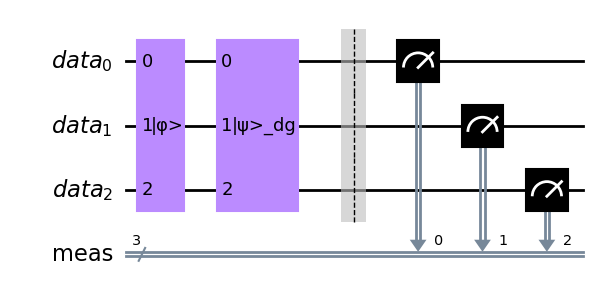

In [24]:
reg_data = QuantumRegister(data_width, name='data')
circuit = QuantumCircuit(reg_data)

circuit.append(phi_circuit, qargs=reg_data)
# psi_circuit.inverse() -> psi_circuitの逆回路
circuit.append(psi_circuit.inverse(), qargs=reg_data)

circuit.measure_all()

circuit.draw('mpl')

ポイントは`psi_circuit.inverse()`で得られる`psi_circuit`の逆回路です。逆回路とは、ゲートの順番を反転させ、全てのゲートをその逆操作で置き換えたものです。$\ket{0}$から$\ket{\psi}$を作る回路を$U_{\psi}$と表すと、逆回路は$U_{\psi}^{-1}$もしくは$U_{\psi}^{\dagger}$と書かれ、

$$
U_{\psi}^{-1} U_{\psi} \ket{0} = \ket{0}
$$

です。一般に、状態$\ket{\lambda} = \sum_k z_k \ket{k}$を測定して0を得る確率$|z_0|^2$は内積の定義{eq}`inner_product`から$|\braket{0}{\lambda}|^2$と書けるので、上の回路の測定前の状態を$U_{\psi}^{-1} U_{\phi} \ket{0} =: \ket{U^{-1}_{\psi} \phi}$と表すと、

$$
P_0 = |\braket{0}{U^{-1}_{\psi} \phi}|^2
$$

となります。ここから式{eq}`inverse_circuit`を導くには、量子力学と線形代数をよりはっきり結びつけて後者の言葉を使えば簡単ですが、量子回路と量子状態の概念を出発点として式{eq}`inverse_circuit`を証明することもできます。少し本筋から外れてしまいますが、以下に証明を載せておきます。

```{toggle}
まず、任意の量子回路を表す写像$U$と任意の量子状態$\ket{\lambda}, \ket{\theta}$を考えます。量子回路は量子状態を量子状態に移すので、$U\ket{\lambda}$は単位ベクトル、つまり

$$
\lVert U \ket{\lambda} \rVert^2 = 1
$$

です。$\chi$を複素数としたとき、ベクトル$(\ket{\lambda} + \chi \ket{\theta}) / \lVert \ket{\lambda} + \chi \ket{\theta} \rVert$も単位ベクトルなので、

$$
\left\lVert U \frac{\ket{\lambda} + \chi \ket{\theta}}{\lVert \ket{\lambda} + \chi \ket{\theta} \rVert} \right\rVert^2 = 1
$$

したがって

$$
\begin{align}
2 + 2 \mathrm{Re}(\chi \braket{U \lambda}{U \theta}) = 2 + 2 \mathrm{Re}(\chi\braket{\lambda}{\theta}) \\
\therefore \mathrm{Re}(\chi \braket{U \lambda}{U \theta}) = \mathrm{Re}(\chi \braket{\lambda}{\theta})
\end{align}
$$

ここで$\chi=1$と$\chi=i$をそれぞれ考えると、$\braket{U \lambda}{U \theta}$と$\braket{\lambda}{\theta}$の実部と虚部が共に等しいので

$$
\braket{U \lambda}{U \theta} = \braket{\lambda}{\theta}.
$$

ところが右辺は

$$
\braket{\lambda}{\theta} = \braket{\lambda}{U^{-1} U \theta}
$$

でもあり、これが任意の$\theta$で成立するので、結局任意の状態$\rho$で

$$
\braket{\lambda}{U^{-1} \rho} = \braket{U \lambda}{\rho}
$$

が言えます。これより

$$
P_0 = |\braket{0}{U^{-1}_{\psi} \phi}|^2 = |\braket{\psi}{\phi}|^2
$$

です。
```

上の回路で式{eq}`inverse_circuit`を確認しましょう。

In [25]:
shots = 1000000

circuit = transpile(circuit, backend=simulator)
counts = simulator.run(circuit, shots=shots).result().get_counts()

print(counts['000'] / shots)

0.202916


## 複製不可能定理とテレポーテーション

量子アルゴリズムを考え、実装する時に非常に重要なのが、**任意の未知の量子状態の独立な複製を作る量子回路は存在しない**という複製不可能定理（no-cloning theorem）です。この定理は具体的には、入力状態$\ket{\psi}_{\mathrm{in}}$と、同じビット数の初期化した出力レジスタ$\ket{0}_{\mathrm{out}}$がある時、$\psi$に依存しない回路$U$で

$$
U (\ket{\psi}_{\mathrm{in}} \ket{0}_{\mathrm{out}}) \sim \ket{\psi}_{\mathrm{in}} \ket{\psi}_{\mathrm{out}}
$$

を実現するものはないということを主張しています。

証明は簡単です。

```{toggle}
二つの入力状態$\psi$と$\phi$を考え、左辺の内積を取ると（上の逆回路での内積計算の証明を利用して）

$$
|\braket{U(\psi_{\mathrm{in}}, 0_{\mathrm{out}})}{U(\phi_{\mathrm{in}}, 0_{\mathrm{out}})}| = |\braket{\psi}{\phi}\braket{0}{0}| = |\braket{\psi}{\phi}|.
$$

ところが右辺の内積は

$$
|\braket{\psi_{\mathrm{in}}, \psi_{\mathrm{out}}}{\phi_{\mathrm{in}}, \phi_{\mathrm{out}}}| = |\braket{\psi}{\phi}|^2.
$$

等価関係$\sim$は位相を無視して同値ということだったので、両辺の内積のノルムは等しいはずであり、

$$
|\braket{\psi}{\phi}| = |\braket{\psi}{\phi}|^2.
$$

これは$|\braket{\psi}{\phi}|=0$または$|\braket{\psi}{\phi}|=1$を意味し、$\ket{\psi}$と$\ket{\phi}$が任意の状態であるという仮定と矛盾します。
```

複製不可能定理は量子回路で実行できる計算のクラスを大幅に制限します。例えば、何かの計算を途中で打ち切ってその時点での量子状態をなんらかのメモリデバイスに保存できたとして、その状態をコピーすることができないので、結局そこから計算を再開できるのは一度だけということになります。

任意の量子状態を複製することはできませんが、あるレジスタの量子状態を他のレジスタに移し替えることは可能です。このような操作を量子テレポーテーションと呼びます。テレポーテーションでは元々のレジスタの量子状態が失われるので、状態をコピーしたことにはなりません。

1ビットの情報を転送する回路は以下のようになります。

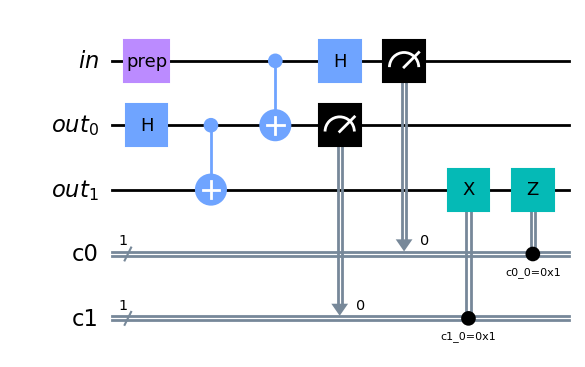

In [26]:
# まずは入力ビットを適当な状態にする回路を作る
# circuit.u (U3 gate)は3パラメータで一つの量子ビットを完全にコントロールするゲート
prep_circuit = QuantumCircuit(1, name='prep')
prep_circuit.u(0.7, 1.8, 2.1, 0)

reg_in = QuantumRegister(1, name='in')
reg_out = QuantumRegister(2, name='out')
res_in = ClassicalRegister(1)
res_ent = ClassicalRegister(1)

circuit = QuantumCircuit(reg_in, reg_out, res_in, res_ent)

# まずreg_inをprep_circuitの状態にする
circuit.append(prep_circuit, qargs=reg_in)

# reg_outはベル状態に用意する
circuit.h(reg_out[0])
circuit.cx(reg_out[0], reg_out[1])

# reg_inとreg_outの第一ビットをエンタングルさせる
circuit.cx(reg_in[0], reg_out[0])

# reg_inにアダマールゲートをかけ、測定する
circuit.h(reg_in[0])
circuit.measure(reg_in[0], res_in[0])

# reg_outのエンタングルしたビットも測定する
circuit.measure(reg_out[0], res_ent[0])

# reg_out[1]にreg_in, reg_entの測定結果に応じたゲートをかける
circuit.x(reg_out[1]).c_if(res_ent[0], 1)
circuit.z(reg_out[1]).c_if(res_in[0], 1)

circuit.draw('mpl')

入力ビットの状態は

In [27]:
Math(statevector_expr(prep_circuit, state_label=r'\text{in}'))

<IPython.core.display.Math object>

回路の終状態は

In [28]:
Math(statevector_expr(circuit, register_sizes=(1, 1, 1)))

<IPython.core.display.Math object>

上のセルを何度か実行すると、右二つのレジスタは実行するごとにランダムに違う値を取るものの、二つの項で共通で、一番左のレジスタが$\ket{\text{in}}$と同じ状態にあることがわかります。このようにテレポーテーションが実際に起こることを、上の回路を元に数式でも確認してみるといいでしょう。